In [1]:
## IMPORTS
# package(s) related to time, space and id
import datetime, time

# package(s) related to the simulation
import simpy
import networkx as nx
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd

# OpenTNSim
from opentnsim import core

# spatial libraries
import shapely.geometry
import shapely.wkt
import pyproj
import shapely.geometry

# define the coorinate system
geod = pyproj.Geod(ellps="WGS84")

## CREATION OF GRAPH
Node = type('Site', (core.Identifiable, core.Log, core.Locatable, core.HasResource), {})
nodes = []
path = []

distances = [550,500,300,500,150,150,500,300,500,550]
coords = []
coords.append([0,0])

for d in range(len(distances)):
    coords.append([pyproj.Geod(ellps="WGS84").fwd(coords[d][0],coords[d][1],90,distances[d])[0],0])

for d in range(len(coords)):
    data_node = {"env": [],
                 "name": "Node " + str(d+1),
                 "geometry": shapely.geometry.Point(coords[d][0], coords[d][1])}
    node = Node(**data_node)
    nodes.append(node)

for i in range(2):
    if i == 0:
        for j in range(len(nodes)-1):
            path.append([nodes[j], nodes[j+1]])
    if i == 1:
        for j in range(len(nodes)-1):
            path.append([nodes[j+1], nodes[j]])

FG = nx.DiGraph()

positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

for edge in path:
    FG.add_edge(edge[0].name, edge[1].name, weight = 1)

## SIMULATION SET-UP
simulation_start = datetime.datetime.now()
env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))

## CREATION OF VESSELS
Vessel = type('Vessel',
          (core.Identifiable, core.Movable, core.HasContainer, core.HasResource, core.Routeable, core.VesselProperties), {})

start_point = 'Node 11'
end_point = 'Node 1'

data_vessel_one = {"env": env,
                   "name": "Vessel",
                   "route": nx.dijkstra_path(FG, start_point, end_point, weight='length'),
                   "geometry": FG.nodes[start_point]['geometry'],
                   "capacity": 1_000,
                   "v": 4,
                   "type": 'CEMT - Va',
                   "B": 10,
                   "H_e": 7.10,
                   "H_f": 5.40,
                   "T_e": 1.8,
                   "T_f": 3.5,
                   "L": 155.0}


env.FG = FG
vessels = []

for v in range(2):
    vessel = Vessel(**data_vessel_one)
    vessels.append(vessel)

## SYSTEM PARAMETERS
# water level difference
wlev_dif = [np.linspace(0,45000,1000),np.zeros(1000)]
for i in range(len(wlev_dif[0])):
    wlev_dif[1][i] = 2

# lock area parameters
waiting_area_1 = core.IsLockWaitingArea(env = env, nr_resources = 1, priority = True,
                                            name = 'Volkeraksluizen_1', node = "Node 2")

lineup_area_1 = core.IsLockLineUpArea(env = env, nr_resources = 1, priority = True,
                                          name = 'Volkeraksluizen_1', node = "Node 3", lineup_length = 300)

lock_1 = core.IsLock(env = env, nr_resources = 100, priority = True, name = 'Volkeraksluizen_1',
                         node_1 = "Node 5", node_2 = "Node 6", node_3 = "Node 7",
                         lock_length = 300, lock_width = 24, lock_depth = 4.5,
                         doors_open = 10 * 60, doors_close = 10 * 60, wlev_dif = wlev_dif, disch_coeff = 0.8,
                         grav_acc = 9.81, opening_area = 4.0, opening_depth = 5.0,
                         simulation_start = simulation_start, operating_time = 25*60)

waiting_area_2 = core.IsLockWaitingArea(env = env, nr_resources = 1, priority = True,
                                            name = "Volkeraksluizen_1", node = "Node 10")

lineup_area_2 = core.IsLockLineUpArea(env = env, nr_resources = 1, priority = True,
                                          name = "Volkeraksluizen_1", node = "Node 9", lineup_length = 300)

lock_1.water_level = "Node 5"

#location of lock areas in graph
FG.nodes["Node 6"]["Lock"] = [lock_1]

FG.nodes["Node 2"]["Waiting area"] = [waiting_area_1]
FG.nodes["Node 3"]["Line-up area"] = [lineup_area_1]

FG.nodes["Node 10"]["Waiting area"] = [waiting_area_2]
FG.nodes["Node 9"]["Line-up area"] = [lineup_area_2]

## INITIATE VESSELS
for vessel in vessels:
    vessel.env = env
    env.process(vessel.move())

## RUN MODEL
env.FG = FG
env.run()

In [2]:
df = pd.DataFrame.from_dict(vessels[1].log)
df
vessels[1].id

'9fa69468-d02e-11eb-888c-18cc18c93a64'

In [3]:
locking_cycle_start_dir1 = simulation_start.timestamp()
locking_cycle_starts_dir1 = []
locking_cycle_stop_dir1 = simulation_start.timestamp()
locking_cycle_stops_dir1 = []
locking_cycle_start_dir2 = simulation_start.timestamp()
locking_cycle_starts_dir2 = []
locking_cycle_stop_dir2 = simulation_start.timestamp()
locking_cycle_stops_dir2 = []

for v in range(0,len(vessels)):
    for t in range(0,len(vessels[v].log["Message"])-1):
        if vessels[v].route[0] == 'Node 1':
            if vessels[v].log["Message"][t] == "Passing lock start":
                if locking_cycle_start_dir1 <= vessels[v].log["Timestamp"][t].timestamp() <= locking_cycle_stop_dir1:
                    pass
                else:
                    locking_cycle_start_dir1 = vessels[v].log["Timestamp"][t-2].timestamp()
                    locking_cycle_starts_dir1.append([vessels[v].log["Timestamp"][t-2].timestamp(),'Start'])
                    locking_cycle_stop_dir1 = vessels[v].log["Timestamp"][t+1].timestamp()
                    for v2 in (range(v,len(vessels))):
                        for t2 in range(0,len(vessels[v2].log["Message"])-1):
                            if vessels[v2].log["Message"][t2] == 'Passing lock stop':
                                if locking_cycle_start_dir1 <= vessels[v2].log["Timestamp"][t2-1].timestamp() <= locking_cycle_stop_dir1 and vessels[v2].route[0] == 'Node 1':                               
                                    if len(locking_cycle_starts_dir1) != len(locking_cycle_stops_dir1):
                                        locking_cycle_stops_dir1.append([vessels[v2].log["Timestamp"][t2+2].timestamp(),'Stop'])
                                    elif vessels[v2].log["Timestamp"][t2+2].timestamp() > locking_cycle_stops_dir1[-1][0]:
                                        locking_cycle_stops_dir1[-1][0] = vessels[v2].log["Timestamp"][t2+2].timestamp()

        elif vessels[v].route[0] == 'Node 21': 
            if vessels[v].log["Message"][t] == "Passing lock start":
                if locking_cycle_start_dir2 <= vessels[v].log["Timestamp"][t].timestamp() <= locking_cycle_stop_dir2:
                    pass
                else:
                    locking_cycle_start_dir2 = vessels[v].log["Timestamp"][t-2].timestamp()
                    locking_cycle_starts_dir2.append([vessels[v].log["Timestamp"][t-2].timestamp(),'Start'])
                    locking_cycle_stop_dir2 = vessels[v].log["Timestamp"][t+1].timestamp()
                    for v2 in (range(v,len(vessels))):
                        for t2 in range(0,len(vessels[v2].log["Message"])-1):
                            if vessels[v2].log["Message"][t2] == 'Passing lock stop':
                                if locking_cycle_start_dir2 <= vessels[v2].log["Timestamp"][t2-1].timestamp() <= locking_cycle_stop_dir2 and vessels[v2].route[0] == 'Node 21':                               
                                    if len(locking_cycle_starts_dir2) != len(locking_cycle_stops_dir2):
                                        locking_cycle_stops_dir2.append([vessels[v2].log["Timestamp"][t2+2].timestamp(),'Stop'])
                                    elif vessels[v2].log["Timestamp"][t2+2].timestamp() > locking_cycle_stops_dir2[-1][0]:
                                        locking_cycle_stops_dir2[-1][0] = vessels[v2].log["Timestamp"][t2+2].timestamp()

inoperation_time_doors1 = locking_cycle_starts_dir2+locking_cycle_stops_dir1
inoperation_time_doors1.sort()
inoperation_time_doors2 = locking_cycle_starts_dir1+locking_cycle_stops_dir2
inoperation_time_doors2.sort()
loop_time_doors1 = []
loop_time_doors2 = []

for i in range(len(inoperation_time_doors1)):
    if i != 0 and inoperation_time_doors1[i][1] == 'Start' and inoperation_time_doors1[i-1][1] != 'Start':
        loop_time_doors1.append((inoperation_time_doors1[i][0]-inoperation_time_doors1[i-1][0])/60)
        
for i in range(len(inoperation_time_doors2)):
    if i != 0 and inoperation_time_doors2[i][1] == 'Start' and inoperation_time_doors2[i-1][1] != 'Start':
        loop_time_doors2.append((inoperation_time_doors2[i][0]-inoperation_time_doors2[i-1][0])/60)

In [4]:
waiting_to_waiting_area = []
waiting_in_waiting_area = []
waiting_in_lineup_area = []
waiting_in_lock = []
total_waiting_time = np.zeros(len(vessels))

for v in range(0,len(vessels)):
    for t in range(0,len(vessels[v].log["Message"])-1):
        if vessels[v].log["Message"][t] == "Waiting to enter waiting area stop":
            waiting_to_waiting_area.append(vessels[v].log["Value"][t]/60)
        if vessels[v].log["Message"][t] == "Waiting in waiting area stop":
            waiting_in_waiting_area.append(vessels[v].log["Value"][t]/60)
        if vessels[v].log["Message"][t] == "Waiting in line-up area stop":
            waiting_in_lineup_area.append(vessels[v].log["Value"][t]/60)
        if vessels[v].log["Message"][t] == "Passing lock stop":
            waiting_in_lock.append(vessels[v].log["Value"][t]/60)
            
for v in range(len(vessels)):
    for t in range(0,len(vessels[v].log["Message"])-1):
        if vessels[v].log["Message"][t] == "Waiting to enter waiting area stop" or vessels[v].log["Message"][t] == "Waiting in waiting area stop" or vessels[v].log["Message"][t] == "Waiting in line-up area stop" or  vessels[v].log["Message"][t] == "Passing lock stop": 
            total_waiting_time[v] += ((vessels[v].log["Value"][t]/60))

In [5]:
def calculate_distance(orig, dest):
    wgs84 = pyproj.Geod(ellps='WGS84')
    
    distance = wgs84.inv(orig[0], orig[1], 
                         dest[0], dest[1])[2]
    
    return distance

vessel_path_x = []
vessel_path_t = []
origin = 'Node 1'
destination = 'Node 11'

for v in range(0,len(vessels)):
    vessel_path_xt = []
    vessel_path_tt = []
    for t in range(0,len(vessels[v].log["Message"])):
        if vessels[v].route[0] == 'Node 1':   
            vessel_path_x0 = (vessels[v].log["Geometry"][0].x,vessels[v].log['Geometry'][0].y)
            vessel_path_t0 = simulation_start.timestamp()
            vessel_path_xt.append(calculate_distance(vessel_path_x0,(vessels[v].log["Geometry"][t].x,vessels[v].log['Geometry'][t].y)))
            vessel_path_tt.append(vessels[v].log["Timestamp"][t].timestamp()-vessel_path_t0)
        if vessels[v].route[0] == 'Node 11':     
            vessel_path_x0 = (vessels[v].log["Geometry"][0].x,vessels[v].log['Geometry'][0].y)
            vessel_path_t0 = simulation_start.timestamp()
            vessel_path_xt.append(calculate_distance((env.FG.nodes[destination]['geometry'].x,env.FG.nodes[destination]['geometry'].y),(env.FG.nodes[origin]['geometry'].x,env.FG.nodes[origin]['geometry'].y))-
                                  calculate_distance(vessel_path_x0,(vessels[v].log["Geometry"][t].x,vessels[v].log['Geometry'][t].y)))
            vessel_path_tt.append(vessels[v].log["Timestamp"][t].timestamp()-vessel_path_t0)
    vessel_path_x.append(vessel_path_xt)
    vessel_path_t.append(vessel_path_tt)

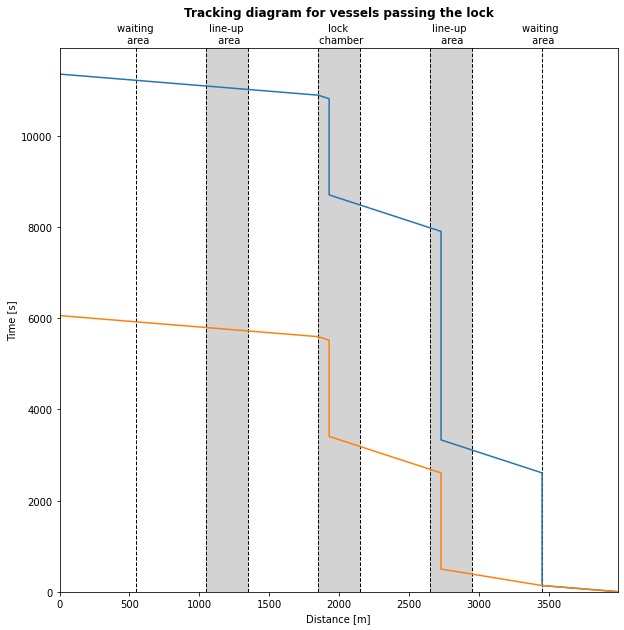

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))
vessel_path_x0 = (FG.nodes['Node 1']['geometry'].x,FG.nodes['Node 1']['geometry'].y)

plt.axvline(x=calculate_distance(vessel_path_x0,(FG.nodes["Node 2"]['geometry'].x,FG.nodes["Node 2"]['geometry'].y)), 
                                                 color = 'k', linestyle = '--', linewidth = 1.0)
plt.axvline(x=calculate_distance(vessel_path_x0,(FG.nodes["Node 3"]['geometry'].x,FG.nodes["Node 3"]['geometry'].y)), 
                                                 color = 'k', linestyle = '--', linewidth = 1.0)
plt.axvline(x=calculate_distance(vessel_path_x0,(FG.nodes["Node 4"]['geometry'].x,FG.nodes["Node 4"]['geometry'].y)), 
                                                 color = 'k', linestyle = '--', linewidth = 1.0)
plt.axvline(x=calculate_distance(vessel_path_x0,(FG.nodes["Node 5"]['geometry'].x,FG.nodes["Node 5"]['geometry'].y)), 
                                                 color = 'k', linestyle = '--', linewidth = 1.0)
plt.axvline(x=calculate_distance(vessel_path_x0,(FG.nodes["Node 7"]['geometry'].x,FG.nodes["Node 7"]['geometry'].y)), 
                                                 color = 'k', linestyle = '--', linewidth = 1.0)
plt.axvline(x=calculate_distance(vessel_path_x0,(FG.nodes["Node 8"]['geometry'].x,FG.nodes["Node 8"]['geometry'].y)), 
                                                 color = 'k', linestyle = '--', linewidth = 1.0)
plt.axvline(x=calculate_distance(vessel_path_x0,(FG.nodes["Node 9"]['geometry'].x,FG.nodes["Node 9"]['geometry'].y)), 
                                                 color = 'k', linestyle = '--', linewidth = 1.0)
plt.axvline(x=calculate_distance(vessel_path_x0,(FG.nodes["Node 10"]['geometry'].x,FG.nodes["Node 10"]['geometry'].y)), 
                                                 color = 'k', linestyle = '--', linewidth = 1.0)
for v in reversed(range(0,len(vessels))):
    plt.plot(vessel_path_x[v],vessel_path_t[v])
    
plt.text(calculate_distance(vessel_path_x0,(FG.nodes["Node 6"]['geometry'].x,FG.nodes["Node 6"]['geometry'].y)),ax.get_ylim()[1]+0.01*ax.get_ylim()[1],'lock \n chamber',horizontalalignment = 'center')
plt.text(calculate_distance(vessel_path_x0,(FG.nodes["Node 9"]['geometry'].x,FG.nodes["Node 9"]['geometry'].y))-
         0.5*calculate_distance((FG.nodes["Node 8"]['geometry'].x,FG.nodes["Node 8"]['geometry'].y),(FG.nodes["Node 9"]['geometry'].x,FG.nodes["Node 9"]['geometry'].y)),ax.get_ylim()[1]+0.01*ax.get_ylim()[1],'line-up \n area',horizontalalignment = 'center')
plt.text(calculate_distance(vessel_path_x0,(FG.nodes["Node 3"]['geometry'].x,FG.nodes["Node 3"]['geometry'].y))+
         0.5*calculate_distance((FG.nodes["Node 3"]['geometry'].x,FG.nodes["Node 3"]['geometry'].y),(FG.nodes["Node 4"]['geometry'].x,FG.nodes["Node 4"]['geometry'].y)),ax.get_ylim()[1]+0.01*ax.get_ylim()[1],'line-up \n area',horizontalalignment = 'center')
plt.text(calculate_distance(vessel_path_x0,(FG.nodes["Node 10"]['geometry'].x,FG.nodes["Node 10"]['geometry'].y)),ax.get_ylim()[1]+0.01*ax.get_ylim()[1],'waiting \n area',horizontalalignment = 'center')
plt.text(calculate_distance(vessel_path_x0,(FG.nodes["Node 2"]['geometry'].x,FG.nodes["Node 2"]['geometry'].y)),ax.get_ylim()[1]+0.01*ax.get_ylim()[1],'waiting \n area',horizontalalignment = 'center')

plt.title("Tracking diagram for vessels passing the lock", fontweight='bold', pad = 32)
plt.xlabel("Distance [m]")
plt.xlim([0,0.95*ax.get_xlim()[1]])
plt.ylim([0,ax.get_ylim()[1]])
plt.ylabel("Time [s]")

plt.fill([calculate_distance(vessel_path_x0,(FG.nodes["Node 5"]['geometry'].x,FG.nodes["Node 5"]['geometry'].y)),
          calculate_distance(vessel_path_x0,(FG.nodes["Node 5"]['geometry'].x,FG.nodes["Node 5"]['geometry'].y)),
          calculate_distance(vessel_path_x0,(FG.nodes["Node 7"]['geometry'].x,FG.nodes["Node 7"]['geometry'].y)), 
          calculate_distance(vessel_path_x0,(FG.nodes["Node 7"]['geometry'].x,FG.nodes["Node 7"]['geometry'].y))],
         [0, ax.get_ylim()[1], ax.get_ylim()[1], 0],'lightgrey')

plt.fill([calculate_distance(vessel_path_x0,(FG.nodes["Node 8"]['geometry'].x,FG.nodes["Node 8"]['geometry'].y)),
          calculate_distance(vessel_path_x0,(FG.nodes["Node 8"]['geometry'].x,FG.nodes["Node 8"]['geometry'].y)),
          calculate_distance(vessel_path_x0,(FG.nodes["Node 9"]['geometry'].x,FG.nodes["Node 9"]['geometry'].y)), 
          calculate_distance(vessel_path_x0,(FG.nodes["Node 9"]['geometry'].x,FG.nodes["Node 9"]['geometry'].y))],
         [0, ax.get_ylim()[1], ax.get_ylim()[1], 0],'lightgrey')

plt.fill([calculate_distance(vessel_path_x0,(FG.nodes["Node 3"]['geometry'].x,FG.nodes["Node 3"]['geometry'].y)),
          calculate_distance(vessel_path_x0,(FG.nodes["Node 3"]['geometry'].x,FG.nodes["Node 3"]['geometry'].y)),
          calculate_distance(vessel_path_x0,(FG.nodes["Node 4"]['geometry'].x,FG.nodes["Node 4"]['geometry'].y)), 
          calculate_distance(vessel_path_x0,(FG.nodes["Node 4"]['geometry'].x,FG.nodes["Node 4"]['geometry'].y))],
         [0, ax.get_ylim()[1], ax.get_ylim()[1], 0],'lightgrey')

plt.show()